# Método Hierárquico Aglomerativo

## Contexto

Faremos um estudo sobre um pequeno conjunto de dados, utilizando a técnica não supervisionada de clustering: Associação Hierárquica Aglomerativa.

Esse método consiste em agrupar as observações em grupos homogêneos internamente e heterogêneos entre si. É uma análise de agrupamentos que se caracteriza por ser exploratória, de modo que não tem caráter preditivo para observações de fora da amostra. Nesse caso, queremos investigar a interdependência entre as variáveis para, assim, criarmos os grupos (clusters).

Nessa técnica, a quantidade de clusters é definida ao longo da análise, seguindo um passo a passo.

Os dados que serão trabalhados são sobre as notas (de 0 a 10) de cinco estudantes em três disciplinas: matemática, física e química. Essas notas são provenientes de um vestibular, no qual um professor de uma faculdade está interessado com a capacidade de aprendizado dos alunos. O objetivo é alocá-los em grupos com a maior homogeneidade possível.

## Importação de bibliotecas e pacotes

In [47]:
# Importando os pacotes necessários
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
import scipy.stats as stats
import pingouin as pg
import plotly.express as px 
import plotly.io as pio
pio.renderers.default='browser'

from scipy.stats import zscore
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering

## Leitura dos dados

In [48]:
# Importando o banco de dados
dados_notas = pd.read_excel('notas.xlsx')

**Fonte:** livro "Manual de Análise de Dados: Estatística e Machine Learning com Excel, SPSS, Stata, R e Python", dos autores Luiz Paulo Fávero e Patrícia Belfiore, 2024, Capítulo 9.

## Análise descritiva

Nessa etapa, iremos estudar os dados através de resumos.

In [ ]:
# Visualização das primeiras linhas 
dados_notas.head()

,estudante,matemática,física,química
0,Gabriela,3.7,2.7,9.1
1,Luiz Felipe,7.8,8.0,1.5
2,Patrícia,8.9,1.0,2.7
3,Ovídio,7.0,1.0,9.0
4,Leonor,3.4,2.0,5.0


In [50]:
# Verificando a dimensão dos dados
dados_notas.shape

(5, 4)

In [51]:
# Tipos de cada variável
dados_notas.dtypes

estudante      object
matemática    float64
física        float64
química       float64
dtype: object

Podemos observar que temos 5 observações e 4 variáveis, sendo uma qualitativa ("estudante") e, as demais, numéricas. 

In [52]:
# Estatísticas descritivas das variáveis
dados_notas.describe()

,matemática,física,química
count,5.000000,5.000000,5.000000
mean,6.160000,2.940000,5.460000
std,2.478508,2.918561,3.510413
min,3.400000,1.000000,1.500000
25%,3.700000,1.000000,2.700000
50%,7.000000,2.000000,5.000000
75%,7.800000,2.700000,9.000000
max,8.900000,8.000000,9.100000


Vale lembrar que as variáveis estão na mesma escala (de 0 a 10), não precisando fazer nenhum tipo de tratamento. Caso não estivessem na mesma escala, seria necessário realizar o processo de padronização pelo procedimento $Z_{scores}$ para então começar a análise de cluster. Esse mecanismo visa tornar as variáveis com média igual e zero e desvio padrão igual a um, através da seguinte fórmula:

$ZX_{ji} = \frac{X_{ji} - \bar{X}}{S_j},$

isto é, a observação menos a média da sua coluna, dividido pelo desvio padrão da coluna. Portanto, seriam utilizados os seguintes comandos:

In [53]:
# Selecionado apenas variáveis métricas
notas = dados_notas.drop(columns=['estudante'])

# Aplicando o procedimento de ZScore
notas_padronizadas = notas.apply(zscore, ddof=1) # ddof=1 é para utilizar o desvio padrão amostral
print(notas_padronizadas)
print("")

# Visualizando o resultado do procedimento (média e desvio padrão)
print(round(notas_padronizadas.mean(), 2))
print("")
print(round(notas_padronizadas.std(), 2))

   matemática    física   química
0   -0.992533 -0.082232  1.036915
1    0.661689  1.733731 -1.128072
2    1.105504 -0.664711 -0.786232
3    0.338914 -0.664711  1.008428
4   -1.113573 -0.322076 -0.131039

matemática    0.0
física        0.0
química       0.0
dtype: float64

matemática    1.0
física        1.0
química       1.0
dtype: float64


Notamos que todas as variáveis métricas ficaram com média igual a zero e desvio padrão igual a um.

Todavia, podemos plotar um gráfico boxplot, evidenciando que as variáveis originais (sem a normalização) já estão na mesma escala.

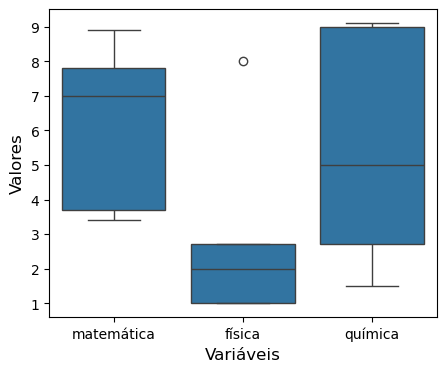

In [54]:
# Boxplot com as três variáveis originais
plt.figure(figsize=(5,4))
sns.boxplot(x='variable', y='value', data=pd.melt(notas))
plt.ylabel('Valores', fontsize=12)
plt.xlabel('Variáveis', fontsize=12)
plt.show()

Agora, como temos três variáveis, podemos plotar um gráfico em três dimensões para observarmos a disposição das observações:

In [55]:
# Gráfico 3D das observações
fig = px.scatter_3d(dados_notas, 
                    x='matemática', 
                    y='química', 
                    z='física',
                    text=dados_notas.estudante)
fig.show()
# Como estamos usando o plotly, o gráfico é mostrado no browser

## Método Hierárquico Aglomerativo

Para aplicarmos a Análise de Cluster Hierárquica, devemos escolher uma medida de distância (dissimilaridade), que é a distância entre as observações. Isso é realizado para sabermos o quão são diferentes as observações entre si. Essas medidas podem ser:

* Euclidiana: $d_{pq} = \sqrt{\sum^k_{j=1}(ZX_{jp} - ZX_{jq})^2}$

* Euclidiana quadrática: $d_{pq} = \sum^k_{j=1}(ZX_{jp} - ZX_{jq})^2$

* Manhattan (City Block): $d_{pq} = \sum^k_{j=1}|ZX_{jp} - ZX_{jq}|$

* Minkowski: $d_{pq} = \left[\sum^k_{j=1}(|ZX_{jp} - ZX_{jq}|)^m\right]^{\frac{1}{m}}$

* Chebychev: $d_{pq} = max|ZX_{jp} - ZX_{jq}|$

Além disso, também escolhemos qual método de encadeamento deve ser usado. Esse processo indica qual distância aplicar quando já existem clusters formados durante os estágios aglomerativos.

Temos três tipos de métodos que podem ser aplicados:

* **Nearest neighbor (single linkage):** considera as menores distâncias. Recomendado para observações distintas.

* **Furthest neighbor (complete linkage):** considera as maiores distâncias. Recomendado para observações parecidas.

* **Between groups (average linkage):** junção de grupos pela distância média entre todos os pares de observações.

Logo, na técnica hierárquica aglomerativa, temos o propósito de juntar em um único cluster as observações inicialmente separadas. Assim, seguimos o seguinte passo a passo:

1. Inicia-se no **estágio 0**, em que, se $n$ observações são consideradas, começamos com $n$ clusters (todas observações separadas);
2. Une-se as duas observações com **menor distância**, ou seja, ficamos com $n-1$ clusters;
3. Na sequência, encontram-se duas novas observações com a menor distância;
4. Repete-se a etapa anterior $n-1$ vezes até restar 1 cluster (todas observações juntas - **último estágio**);
5. Por último, faz-se o **dendrograma** (gráfico para visualizar esses clusters).

Feito o dendrograma, devemos escolher a quantidade de clusters que vamos considerar no estudo. Como critério, pode-se adotar o tamanho dos saltos de distância para a aglomeração posterior. É importante comparar dendrogramas que foram obtidos por diferentes métodos de encadeamento.

### 1. Cluster Hierárquico Aglomerativo

* Distância: Euclidiana;
* Método de encadeamento: Single Linkage.

In [56]:
# Visualizando as distâncias
dist_euclidiana = pdist(notas, metric='euclidean')
dist_euclidiana

array([10.13212712,  8.41961994,  3.71348893,  4.17013189,  7.18679344,
       10.29028668,  8.22253002,  6.58027355,  6.0448325 ,  5.47357287])

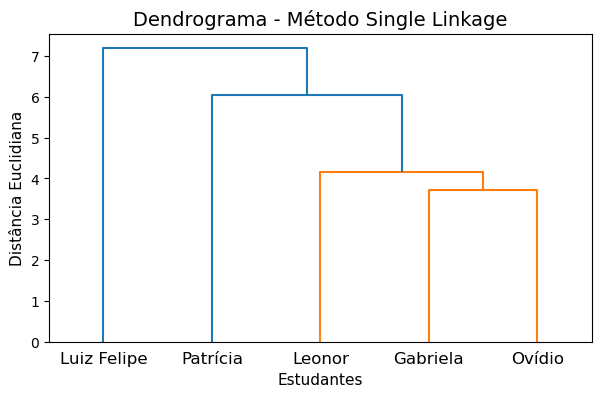

In [57]:
# Gerando o dendrograma para visualização dos clusters
plt.figure(figsize=(7,4))
# Gerando o padrão de aglomeração - Single Linkage:
aglom_single_euclid = sch.linkage(notas, method = 'single', metric = 'euclidean')
# Dendrograma de acordo com a aglomeração acima estabelecida:
dendogram_single_euclid = sch.dendrogram(aglom_single_euclid, labels = list(dados_notas.estudante))
plt.title('Dendrograma - Método Single Linkage', fontsize=14)
plt.xlabel('Estudantes', fontsize=11)
plt.ylabel('Distância Euclidiana', fontsize=11)
plt.show()

Com base no dendrograma acima, temos no eixo $y$ as distâncias euclidianas, mostrando onde ocorreram as uniões. Sendo assim, os estudantes Grabriela e Ovídio formam o primeiro cluster (com Luiz Felipe, Patrícia e Leonor sendo observações individuais), pois possuem a menor distância entre os pares de observações. Em seguida, a Leonor foi adicionada nesse primeiro cluster, formando o segundo cluster. Depois, a Patrícia foi inserida e, por último, o Luiz Felipe.

Tendo isso em vista, escolhemos a quantidade de clusters com base na **maior** distância (salto) entre um cluster e outro, ou seja, encontramos a maior "altura" (em termos de distância) a fim de "encerrar" o processo de clusterização. Observamos que, ao incluir a Leonor no primeiro cluster, houve um pequeno salto. Isso significa que a Leonor não é muito diferente da Gabriela e do Ovídio.

Contudo, ao adicionar a Patrícia ao cluster anterior, tivemos um grande salto de distância. Isso indica que incluímos uma observação um pouco mais distinta; ela não se assemelha aos demais. Para adicionar o Luiz Felipe, tivemos um salto mediano. Portanto, para escolhermos a quantidade de clusters, evitamos os saltos de distâncias mais elevados. Podemos traçar uma linha na horizontal evidenciando o corte a ser realizado.

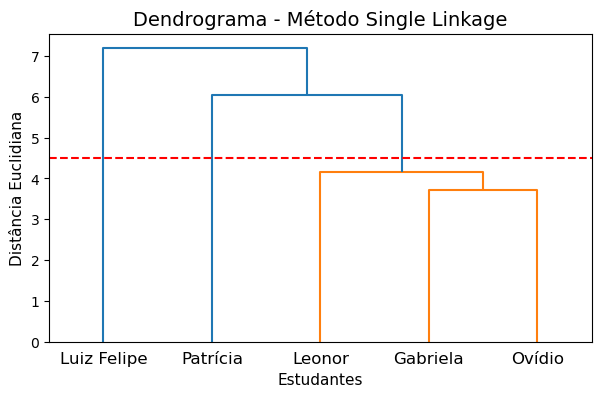

In [58]:
# Gerando o mesmo dendrograma acima com a linha de corte
plt.figure(figsize=(7,4))
aglom_single_euclid = sch.linkage(notas, method = 'single', metric = 'euclidean')
dendrogram_single_euclid = sch.dendrogram(aglom_single_euclid, color_threshold = 4.5, labels = list(dados_notas.estudante))
plt.title('Dendrograma - Método Single Linkage', fontsize=14)
plt.xlabel('Estudantes', fontsize=11)
plt.ylabel('Distância Euclidiana', fontsize=11)
plt.axhline(y = 4.5, color = 'red', linestyle = '--') # Acrescenta uma linha vermelha de altura (distância) igual a 4.5
# Se quisermos mudar o valor de 4.5 para outro qualquer, devemos alterar também na função "sch.dendrogram",
# pois irá pintar da mesma cor as observações que estão no mesmo cluster
plt.show()

Dessa maneira, a altura escolhida foi de 4.5, pois é nessa parte em que ocorre o maior salto. Embora esse seja o melhor critério de separação para esse tipo de aglomeração, nada impede que consideremos outro valor para o corte. Fica a critério de quem está fazendo o estudo. 

Para sabermos quantos clusters foram formados, basta contar quantas vezes a linha vermelha (horizontal) corta as linhas verticais. Então, nesse caso, temos três clusters, sendo eles:

* Luiz Felipe (cluster 1);
* Patrícia (cluster 2);
* Leonor, Gabriela e Ovídio (cluster 3).

Após esse processo, é recomendado gerar no banco de dados uma variável categórica que informa qual cluster cada observação pertence. Como já obervamos e adotamos um total de três clusters no dendrograma, aplicamos a função "AgglomerativeClustering" com esse total de clusters. A distância e o método de encadeamento são mantidos.

In [59]:
# Gerando a variável categórica com a indicação do cluster no dataset
cluster_single_euclid = AgglomerativeClustering(n_clusters = 3, metric = 'euclidean', linkage = 'single')
indica_cluster_single = cluster_single_euclid.fit_predict(notas) # "fit_predict" prediz qual cluster a observação pertence
dados_notas['cluster_single'] = indica_cluster_single
dados_notas['cluster_single'] = dados_notas['cluster_single'].astype('category')
dados_notas

,estudante,matemática,física,química,cluster_single
0,Gabriela,3.7,2.7,9.1,0
1,Luiz Felipe,7.8,8.0,1.5,1
2,Patrícia,8.9,1.0,2.7,2
3,Ovídio,7.0,1.0,9.0,0
4,Leonor,3.4,2.0,5.0,0


Agora, temos uma coluna a mais em relação ao banco de dados original. Cada observação foi preenchida com um número que representa seu cluster, podendo ser 0, 1 ou 2.

Para fins de análise, podemos verificar os coeficientes desse dendrograma, que representam as "alturas" (distâncias) em que as observações foram unidas.

In [ ]:
# Coeficientes do dendrograma - Single Linkage
coef_single_euclid = [y[1] for y in dendrogram_single_euclid['dcoord']]
coef_single_euclid

[3.713488925525428, 4.170131892398609, 6.044832503882965, 7.1867934435323795]

Assim, as uniões ocorreram a uma distância de $3.71$ no estágio 1, $4.17$ no estágio 2, $6.04$ no estãgio 3 e $7.19$ no estágio 4. Nota-se que a maior diferença ocorreu entre os estágios 2 e 3.

#### Conclusão - Método Single Linkage

De acordo com o trabalho realizado, concluímos que, ao aplicarmos o Método Hierárquico Aglomerativo com distância Euclidiana e técnica de encadeamento Single Linkage, definimos um total de três clusters.

**Obs.:** esse resultado só é válido para as observações e as variáveis consideradas antes da aplicação do método. Se novas observações ou variáveis forem tanto adicionadas quanto retiradas do conjunto de dados, será necessário realizar um novo estudo, com novos agrupamentos, pois a inclusão ou exclusão de informações pode alterar a composição de cada cluster. Esse tipo de agrupamento não possui caráter preditivo.

### 2. Cluster Hierárquico Aglomerativo

* Distância: Euclidiana;
* Método de encadeamento: Complete Linkage.

As distâncias são as mesmas que foram consideradas pelo método de encadeamento Single Linkage (distância Euclidiana).

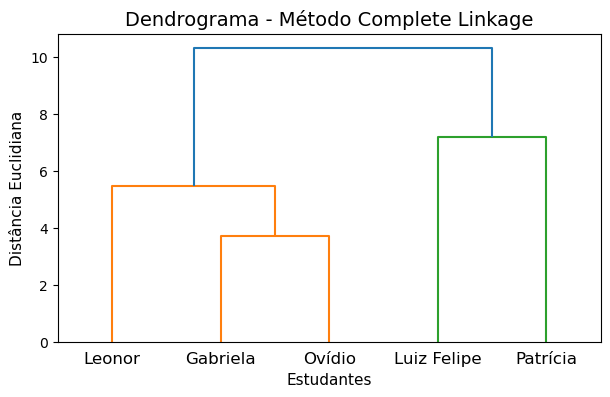

In [61]:
# Gerando o dendrograma para visualização dos clusters
plt.figure(figsize=(7,4))
# Gerando o padrão de aglomeração - Complete Linkage:
aglom_complete_euclid = sch.linkage(notas, method = 'complete', metric = 'euclidean')
# Dendrograma de acordo com a aglomeração acima estabelecida:
dendrogram_complete_euclid = sch.dendrogram(aglom_complete_euclid, labels = list(dados_notas.estudante))
plt.title('Dendrograma - Método Complete Linkage', fontsize=14)
plt.xlabel('Estudantes', fontsize=11)
plt.ylabel('Distância Euclidiana', fontsize=11)
plt.show()

Com base no dendrograma acima, temos no eixo $y$ as distâncias euclidianas, mostrando onde ocorreram as uniões. Da mesma maneira que o dendrograma anterior (Single Linkage), os estudantes Grabriela e Ovídio formam o primeiro cluster (com Luiz Felipe, Patrícia e Leonor sendo observações individuais). Em seguida, a Leonor foi adicionada nesse primeiro cluster, formando o segundo cluster. Depois, Patrícia e Luiz Felipe formam um cluster distinto.

Logo, como a maior distância ocorre após a formação dos cluster Gabriela-Ovídio-Leonor, escolhemos a distância (altura) igual a 6, ficando com três clusters. Assim, evitamos a inclusão de grandes saltos que, consequentemente, as observações são mais distintas entre si. Podemos traçar uma linha na horizontal evidenciando o corte a ser realizado.

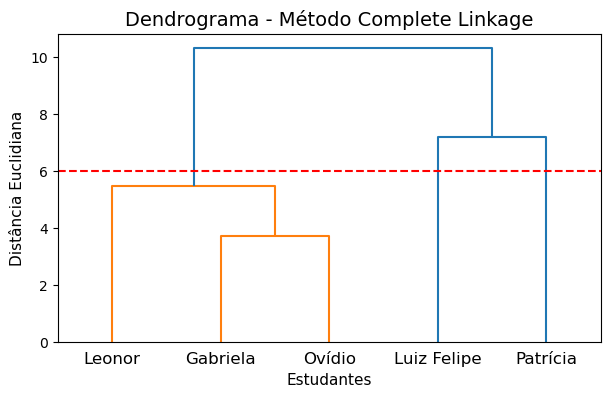

In [62]:
# Gerando o mesmo dendrograma acima com a linha de corte
plt.figure(figsize=(7,4))
aglom_complete_euclid = sch.linkage(notas, method = 'complete', metric = 'euclidean')
dendrogram_complete_euclid = sch.dendrogram(aglom_complete_euclid, color_threshold = 6, labels = list(dados_notas.estudante))
plt.title('Dendrograma - Método Complete Linkage', fontsize=14)
plt.xlabel('Estudantes', fontsize=11)
plt.ylabel('Distância Euclidiana', fontsize=11)
plt.axhline(y = 6, color = 'red', linestyle = '--') # Acrescenta uma linha vermelha de altura (distância) igual a 6
# Se quisermos mudar o valor de 6 para outro qualquer, devemos alterar também na função "sch.dendrogram",
# pois irá pintar da mesma cor as observações que estão no mesmo cluster
plt.show()

Portanto, com a altura igual a 6, separamos as observações em três clusters:

* Leonor, Gabriela e Ovídio (cluster 1);
* Luiz Felipe (cluster 2);
* Patrícia (cluster 3).

Embora esse seja o melhor critério de separação para esse tipo de aglomeração, seria possível considerar outro valor para o corte, por exemplo 9, no qual dividiria as observações em apenas dois clusters.

Finalizada a clusterização, criaremos a variável categórica que indica qual cluster cada observação pertence.

In [63]:
# Gerando a variável categórica com a indicação do cluster no dataset
cluster_complete_euclid = AgglomerativeClustering(n_clusters = 3, metric = 'euclidean', linkage = 'complete')
indica_cluster_complete = cluster_complete_euclid.fit_predict(notas)
dados_notas['cluster_complete'] = indica_cluster_complete
dados_notas['cluster_complete'] = dados_notas['cluster_complete'].astype('category')
dados_notas

,estudante,matemática,física,química,cluster_single,cluster_complete
0,Gabriela,3.7,2.7,9.1,0,0
1,Luiz Felipe,7.8,8.0,1.5,1,2
2,Patrícia,8.9,1.0,2.7,2,1
3,Ovídio,7.0,1.0,9.0,0,0
4,Leonor,3.4,2.0,5.0,0,0


Desse modo, temos mais uma coluna em relação ao banco de dados original. Cada observação foi preenchida com um número que representa seu cluster, podendo ser 0, 1 ou 2, mantendo o mesmo padrão de classificação do Single Linkage. Os números das categorias podem ser diferentes de um método de encadeamento para outro, mas o que importa é a divisão em clusters conforme o dendrograma.

Como feito anteriormente, verificaremos os coeficientes desse dendrograma.

In [64]:
# Coeficientes do dendrograma - Complete Linkage
coef_complete_euclid = [y[1] for y in dendrogram_complete_euclid['dcoord']]
coef_complete_euclid

[3.713488925525428, 5.473572873361603, 7.1867934435323795, 10.290286682109492]

Assim, as uniões ocorreram a uma distância de $3.71$ no estágio 1, $5.47$ no estágio 2, $7.19$ no estãgio 3 e $10.29$ no estágio 4. Nota-se que a maior diferença ocorreu entre os estágios 3 e 4.

#### Conclusão - Método Complete Linkage

Isto posto, concluímos que, ao aplicarmos o Método Hierárquico Aglomerativo com distância Euclidiana e técnica de encadeamento Complete Linkage, definimos um total de três clusters, que são os mesmos obtidos através do Single Linkage.

### 3. Cluster Hierárquico Aglomerativo

* Distância: Euclidiana;
* Método de encadeamento: Average Linkage.

As distâncias consideradas são as mesmas (Euclidiana).

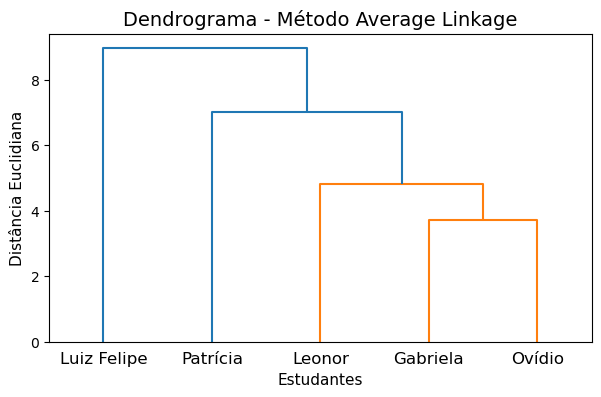

In [65]:
# Gerando o dendrograma para visualização dos clusters
plt.figure(figsize=(7,4))
# Gerando o padrão de aglomeração - Average Linkage:
aglom_average_euclid = sch.linkage(notas, method = 'average', metric = 'euclidean')
# Dendrograma de acordo com a aglomeração acima estabelecida:
dendrogram_average_euclid = sch.dendrogram(aglom_average_euclid, labels = list(dados_notas.estudante))
plt.title('Dendrograma - Método Average Linkage', fontsize=14)
plt.xlabel('Estudantes', fontsize=11)
plt.ylabel('Distância Euclidiana', fontsize=11)
plt.show()

Da mesma forma que o dendrograma Single Linkage, o maior salto ocorre do estágio 2 para o 3, no qual Luiz Felipe forma o primeiro cluster, Patrícia o segundo e, Grabriela e Ovídio, o terceiro.

Assim, como a maior distância ocorre após a formação dos cluster Gabriela-Ovídio-Leonor, escolhemos a distância (altura) igual a 6, selecionando três clusters. Como próximo passo, podemos traçar uma linha na horizontal evidenciando o corte a ser realizado.

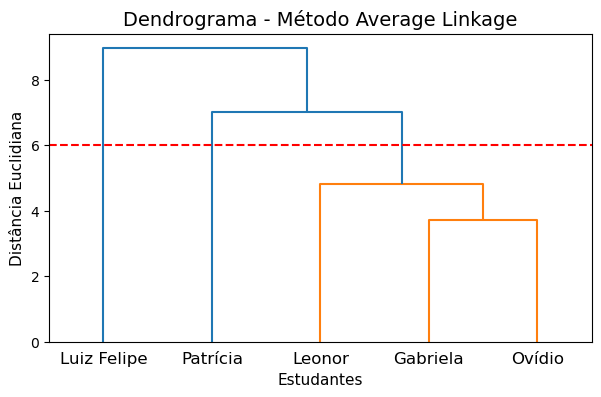

In [66]:
# Gerando o mesmo dendrograma acima com a linha de corte
plt.figure(figsize=(7,4))
aglom_average_euclid = sch.linkage(notas, method = 'average', metric = 'euclidean')
dendrogram_average_euclid = sch.dendrogram(aglom_average_euclid, color_threshold = 6, labels = list(dados_notas.estudante))
plt.title('Dendrograma - Método Average Linkage', fontsize=14)
plt.xlabel('Estudantes', fontsize=11)
plt.ylabel('Distância Euclidiana', fontsize=11)
plt.axhline(y = 6, color = 'red', linestyle = '--') # Acrescenta uma linha vermelha de altura (distância) igual a 6
# Se quisermos mudar o valor de 6 para outro qualquer, devemos alterar também na função "sch.dendrogram",
# pois irá pintar da mesma cor as observações que estão no mesmo cluster
plt.show()

Portanto, com a altura igual a 6, separamos as observações em três clusters:

* Leonor, Gabriela e Ovídio (cluster 1);
* Patrícia (cluster 2);
* Luiz Felipe (cluster 3).

Finalizada a clusterização, criaremos a variável categórica que indica qual cluster cada observação pertence.

In [67]:
# Gerando a variável categórica com a indicação do cluster no dataset
cluster_average_euclid = AgglomerativeClustering(n_clusters = 3, metric = 'euclidean', linkage = 'average')
indica_cluster_average = cluster_average_euclid.fit_predict(notas)
dados_notas['cluster_average'] = indica_cluster_complete
dados_notas['cluster_average'] = dados_notas['cluster_average'].astype('category')
dados_notas

,estudante,matemática,física,química,cluster_single,cluster_complete,cluster_average
0,Gabriela,3.7,2.7,9.1,0,0,0
1,Luiz Felipe,7.8,8.0,1.5,1,2,2
2,Patrícia,8.9,1.0,2.7,2,1,1
3,Ovídio,7.0,1.0,9.0,0,0,0
4,Leonor,3.4,2.0,5.0,0,0,0


Com base na tabela acima, notamos que a clusterização, usando o método Average Linkage, resulta nos mesmos grupos que os demais métodos.

In [68]:
# Coeficientes do dendrograma - Average Linkage
coef_average_euclid = [y[1] for y in dendrogram_average_euclid['dcoord']]
coef_average_euclid

[3.713488925525428, 4.821852382880106, 7.014908666114838, 8.957934317775708]

Dessa forma, as uniões ocorreram a uma distância de $3.71$ no estágio 1, $4.82$ no estágio 2, $7.01$ no estãgio 3 e $8.96$ no estágio 4. Nota-se que a maior diferença ocorreu entre os estágios 2 e 3.

**Obs.:** a menor distância é sempre a mesma, independente do método de encadeamento.

#### Conclusão - Método Average Linkage

À vista disso, concluímos que, ao aplicarmos o Método Hierárquico Aglomerativo com distância Euclidiana e técnica de encadeamento Average Linkage, definimos um total de três clusters, que são os mesmos obtidos através do Single Linkage e do Complete Linkage.

## Conclusão final

Depois de aplicar os três métodos de encadeamento, determinamos que o número de clusters a ser considerado será 3 para o conjunto de dados sobre as notas dos estudantes.